# Text Mining Final Project
## Multi-Class Classification of Tokopedia Product Reviews

### Project Overview
This project implements a **multi-class text classification system** for Tokopedia product reviews. Unlike traditional sentiment analysis (positive/negative), this project categorizes reviews into five distinct classes:

1. **Kritik** (Complaints/Problems)
2. **Saran** (Suggestions/Recommendations)
3. **Pujian** (Positive Appreciation)
4. **Informasi/Netral** (Descriptive/Neutral)
5. **Lainnya** (Noise/Irrelevant)

# 1. Environment Setup & CUDA Verification

In [1]:
# CUDA Verification and Device Setup
import torch
import sys
import platform

print("=" * 70)
print("SYSTEM INFORMATION")
print("=" * 70)
print(f"Python Version: {sys.version}")
print(f"Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()

print("=" * 70)
print("CUDA & GPU INFORMATION")
print("=" * 70)
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"cuDNN Version: {torch.backends.cudnn.version()}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    
    # Set device to GPU 0 (RTX 3050 Ti)
    device = torch.device('cuda:0')
    torch.cuda.set_device(0)
    
    # GPU optimizations
    torch.backends.cudnn.benchmark = True  # Enable cuDNN auto-tuner for faster training
    torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 on Ampere GPUs for faster matmul
    torch.backends.cudnn.allow_tf32 = True  # Allow TF32 on Ampere GPUs for faster cudnn
    
    print(f"\n✓ Using device: {device} ({torch.cuda.get_device_name(0)})")
    print("✓ GPU optimizations enabled (cuDNN benchmark, TF32)")
else:
    device = torch.device('cpu')
    print("\nCUDA not available. Using CPU.")
print("=" * 70)

SYSTEM INFORMATION
Python Version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-11-10.0.26100-SP0
PyTorch Version: 2.7.1+cu118

CUDA & GPU INFORMATION
CUDA Available: True
CUDA Version: 11.8
cuDNN Version: 90100
Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
GPU Memory: 4.00 GB

✓ Using device: cuda:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU)
✓ GPU optimizations enabled (cuDNN benchmark, TF32)


In [46]:
# Import All Required Libraries
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and analysis
import numpy as np
import pandas as pd
from collections import Counter
import re
import string
import time
from datetime import datetime
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP - Indonesian language processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder

# Deep Learning - PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Utilities
import joblib
from tqdm import tqdm

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [3]:
# Download NLTK data (run once)
print("Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
print("✓ NLTK data downloaded successfully!")

✓ NLTK data downloaded successfully!


# 2. Project Summary

## Executive Summary

This project addresses the challenge of automatically categorizing Indonesian product reviews from Tokopedia into **five distinct classes** that go beyond simple sentiment analysis. Traditional sentiment classifiers only distinguish between positive, negative, and neutral opinions. However, e-commerce platforms require more granular insights to:

- Identify **specific complaints** that need immediate attention
- Extract **actionable suggestions** for product improvement
- Recognize **genuine praise** for marketing purposes
- Filter **neutral/informational** content
- Remove **noise and irrelevant** entries

### Research Objectives

1. Design a **label engineering strategy** to convert rating-based reviews into multi-class categories
2. Build a comprehensive **Indonesian text preprocessing pipeline** using Sastrawi
3. Compare **classical machine learning** (SVM with TF-IDF) against **transformer-based models** (IndoBERT)
4. Evaluate the impact of **hyperparameter tuning** on model performance
5. Provide **business insights** for Tokopedia sellers and the platform

### Methodology

- **Dataset**: 100,000+ Indonesian product reviews from Tokopedia (2019)
- **Labels**: Kritik, Saran, Pujian, Informasi/Netral, Lainnya
- **Models**: 6 models total (SVM baseline/tuned, IndoBERT-p1 baseline/tuned, IndoBERT-p2 baseline/tuned)
- **Hardware**: NVIDIA RTX 3050 Ti with CUDA acceleration
- **Evaluation**: Accuracy, Precision, Recall, F1-Score, Confusion Matrix

### Expected Outcomes

- High-quality multi-class classifier for Indonesian reviews
- Comparative analysis of shallow vs. deep learning approaches
- Interpretable insights into model predictions
- Production-ready models and preprocessing pipelines

# 3. Data Collection & Understanding

In [4]:
# Load the dataset
df = pd.read_csv('tokopedia-product-reviews-2019.csv', index_col=0)

print("=" * 70)
print("DATASET INFORMATION")
print("=" * 70)
print(f"Number of reviews: {len(df):,}")
print(f"Number of columns: {len(df.columns)}")
print(f"\nDataset shape: {df.shape}")
print("\n" + "=" * 70)
df.info()
print("\n" + "=" * 70)

DATASET INFORMATION
Number of reviews: 40,607
Number of columns: 8

Dataset shape: (40607, 8)

<class 'pandas.core.frame.DataFrame'>
Index: 40607 entries, 1 to 40893
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          40607 non-null  object
 1   rating        40607 non-null  int64 
 2   category      40607 non-null  object
 3   product_name  40607 non-null  object
 4   product_id    40607 non-null  int64 
 5   sold          40593 non-null  object
 6   shop_id       40607 non-null  int64 
 7   product_url   40607 non-null  object
dtypes: int64(3), object(5)
memory usage: 2.8+ MB



In [5]:
# Display first few rows
print("=" * 70)
print("SAMPLE DATA (First 5 rows)")
print("=" * 70)
df.head()

SAMPLE DATA (First 5 rows)


,text,rating,category,product_name,product_id,sold,shop_id,product_url
1,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,https://www.tokopedia.com/shakaonline87/staple...
2,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
3,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
4,ya saya puas dgn barangnya,5,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,102279869,5,771395,https://www.tokopedia.com/kamarmesin/alat-stap...
5,Responya luar biasa b mantap,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,190679689,787,969999,https://www.tokopedia.com/mitrapersada/isi-ref...


In [6]:
# Check for missing values
print("=" * 70)
print("MISSING VALUES ANALYSIS")
print("=" * 70)
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_df.to_string(index=False))
print("\n" + "=" * 70)

# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
print("=" * 70)

MISSING VALUES ANALYSIS
      Column  Missing Count  Missing Percentage
        text              0                0.00
      rating              0                0.00
    category              0                0.00
product_name              0                0.00
  product_id              0                0.00
        sold             14                0.03
     shop_id              0                0.00
 product_url              0                0.00

Number of duplicate rows: 0


In [7]:
# Display sample reviews from different ratings
print("=" * 70)
print("SAMPLE REVIEWS BY RATING")
print("=" * 70)

for rating in sorted(df['rating'].unique()):
    sample = df[df['rating'] == rating]['text'].iloc[0]
    print(f"\n★ Rating {rating}:")
    print(f"   \"{sample}\"")
    
print("\n" + "=" * 70)

SAMPLE REVIEWS BY RATING

★ Rating 1:
   "barang yg dikirim tidak sesuai pesanan"

★ Rating 2:
   "Pesanan gx sesuai dgn yg d gambar"

★ Rating 3:
   "Sayang produk yg datang di paking kurang rapi sehingga kebuka n isinya terhambur.  Saran klo mengirimkan isi paku tembak seperti ini di beri lakban dulu dikemasan pakunya baru di gabung kan dgn yg lain supaya tidak tercecer. Untuk kualitas barang seperinya bagus walau saya belum coba.  Terima kasih"

★ Rating 4:
   "Barang bagus sesuai info fast response"

★ Rating 5:
   "Barang sesuai pesanan dan cepat sampai"



In [8]:
# Handle missing values - drop rows with missing 'sold' values (only 14 rows)
df_clean = df.dropna().copy()
print(f"✓ Dataset cleaned: {len(df)} → {len(df_clean)} rows ({len(df) - len(df_clean)} rows removed)")
print(f"✓ Final dataset shape: {df_clean.shape}")

✓ Dataset cleaned: 40607 → 40593 rows (14 rows removed)
✓ Final dataset shape: (40593, 8)


# 4. Exploratory Data Analysis (EDA)

In [15]:
# Analyze vocabulary after preprocessing
print("=" * 70)
print("VOCABULARY ANALYSIS AFTER PREPROCESSING")
print("=" * 70)

# Get all unique words from preprocessed text
all_words = []
for text in df_clean['text_preprocessed']:
    all_words.extend(str(text).split())

# Count unique words
unique_words = set(all_words)
word_freq = Counter(all_words)

print(f"\nTotal kata unik setelah cleaning: {len(unique_words):,}")

# Identify non-standard words (likely English or uncommon words)
# We'll consider words that are likely English or not Indonesian stopwords
indonesian_common_words = set([
    'barang', 'bagus', 'puas', 'terima', 'kasih', 'cepat', 'sampai', 'kirim',
    'kualitas', 'harga', 'paket', 'produk', 'toko', 'penjual', 'pembeli',
    'pesan', 'sesuai', 'gambar', 'deskripsi', 'mantap', 'recomend', 'oke',
    'seller', 'packing', 'pengiriman', 'ekspedisi', 'kurir', 'alamat',
    'warna', 'ukuran', 'bahan', 'kualitas', 'original', 'ori', 'real'
])

# Find words that are likely non-standard (contains English patterns or numbers)
non_standard_words = {}
for word, freq in word_freq.items():
    # Check if word contains common English patterns or is not in Indonesian common words
    if len(word) > 3:  # Only words longer than 3 chars
        # Simple heuristic: if word is not in Indonesian common words and has reasonable frequency
        if word not in indonesian_common_words and freq > 5:
            # Check if it looks like English (contains common English letter patterns)
            if any(pattern in word for pattern in ['game', 'play', 'load', 'download', 'character', 
                                                     'heroes', 'story', 'reward', 'quest', 'level',
                                                     'shop', 'store', 'item', 'quality', 'price',
                                                     'seller', 'buyer', 'delivery', 'fast', 'good']):
                non_standard_words[word] = freq

# Sort by frequency
top_non_standard = sorted(non_standard_words.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Kata Non-Standar:")
print("-" * 27)
for word, freq in top_non_standard:
    print(f"  {word}: {freq}")

print("\n" + "=" * 70)
print("INTERPRETASI:")
print("• Kata-kata ini mungkin merupakan:")
print("  - Kata bahasa Inggris yang sering digunakan dalam review")
print("  - Istilah teknis atau brand names")
print("  - Kata slang atau tidak formal")
print("• Menunjukkan pengaruh bahasa Inggris dalam review Indonesia")
print("=" * 70)

VOCABULARY ANALYSIS AFTER PREPROCESSING

Total kata unik setelah cleaning: 12,032

Top 10 Kata Non-Standar:
---------------------------
  fast: 1749
  good: 1336
  delivery: 191
  quality: 174
  sellernya: 115
  store: 63
  item: 50
  price: 42
  request: 31
  display: 30

INTERPRETASI:
• Kata-kata ini mungkin merupakan:
  - Kata bahasa Inggris yang sering digunakan dalam review
  - Istilah teknis atau brand names
  - Kata slang atau tidak formal
• Menunjukkan pengaruh bahasa Inggris dalam review Indonesia


In [9]:
# Calculate text statistics
df_clean['text_length'] = df_clean['text'].str.len()
df_clean['word_count'] = df_clean['text'].str.split().str.len()

print("=" * 70)
print("TEXT STATISTICS")
print("=" * 70)
print(f"\nTotal reviews: {len(df_clean):,}")
print(f"\n{'Metric':<25} {'Min':>10} {'Mean':>10} {'Median':>10} {'Max':>10}")
print("-" * 70)
print(f"{'Character Length':<25} {df_clean['text_length'].min():>10} {df_clean['text_length'].mean():>10.1f} {df_clean['text_length'].median():>10.0f} {df_clean['text_length'].max():>10}")
print(f"{'Word Count':<25} {df_clean['word_count'].min():>10} {df_clean['word_count'].mean():>10.1f} {df_clean['word_count'].median():>10.0f} {df_clean['word_count'].max():>10}")
print("=" * 70)

TEXT STATISTICS

Total reviews: 40,593

Metric                           Min       Mean     Median        Max
----------------------------------------------------------------------
Character Length                   5       55.4         43       1274
Word Count                         1        7.9          6        208


In [16]:
# Save df_clean dataset to CSV
output_path = 'df_clean.csv'
df_clean.to_csv(output_path, index=False)
print(f"Dataset saved successfully to: {output_path}")
print(f"Total rows: {len(df_clean):,}")
print(f"Total columns: {len(df_clean.columns)}")

Dataset saved successfully to: df_clean.csv
Total rows: 40,223
Total columns: 12


WORD CLOUDS BY LABEL


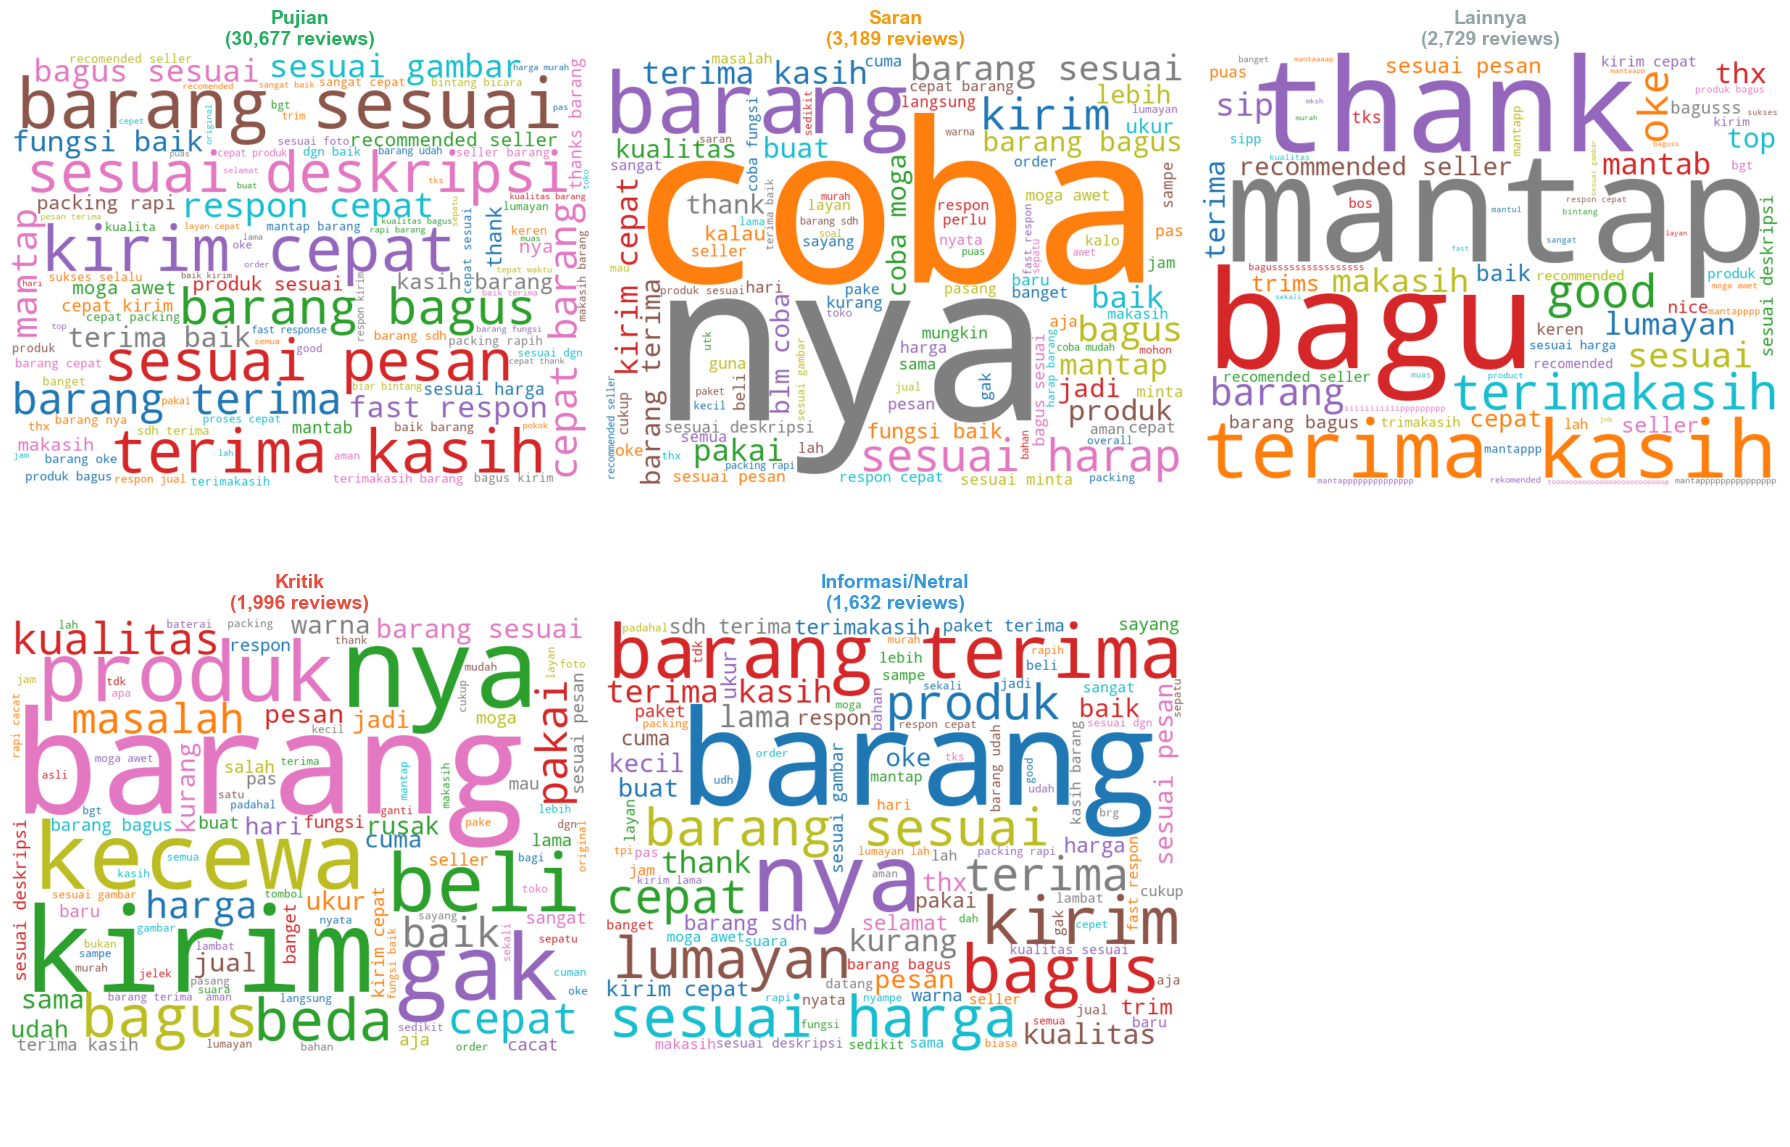


INTERPRETATION:
• Larger words = more frequent in that category
• Each label shows distinct word patterns:
  - Kritik: negative words (rusak, lama, buruk)
  - Saran: suggestion words (tolong, harap, sebaiknya)
  - Pujian: positive words (bagus, puas, cepat)
  - Informasi/Netral: neutral/descriptive words
  - Lainnya: short/unclear patterns


In [17]:
# Create Word Clouds for Each Label
print("=" * 70)
print("WORD CLOUDS BY LABEL")
print("=" * 70)

# Get unique labels
unique_labels = df_clean['label'].unique()
n_labels = len(unique_labels)

# Create subplots - 2 rows for 5 labels
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Define colors for each label
label_colors = {
    'Kritik': '#e74c3c',
    'Saran': '#f39c12',
    'Pujian': '#27ae60',
    'Informasi/Netral': '#3498db',
    'Lainnya': '#95a5a6'
}

for idx, label in enumerate(unique_labels):
    # Get all preprocessed text for this label
    label_texts = df_clean[df_clean['label'] == label]['text_preprocessed']
    combined_text = ' '.join(label_texts.astype(str))
    
    # Create word cloud
    wordcloud = WordCloud(
        width=800,
        height=600,
        background_color='white',
        colormap='tab10',
        max_words=100,
        relative_scaling=0.5,
        min_font_size=10
    ).generate(combined_text)
    
    # Plot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f'{label}\n({len(label_texts):,} reviews)', 
                       fontsize=14, fontweight='bold', 
                       color=label_colors.get(label, 'black'))

# Hide unused subplot
if n_labels < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("• Larger words = more frequent in that category")
print("• Each label shows distinct word patterns:")
print("  - Kritik: negative words (rusak, lama, buruk)")
print("  - Saran: suggestion words (tolong, harap, sebaiknya)")
print("  - Pujian: positive words (bagus, puas, cepat)")
print("  - Informasi/Netral: neutral/descriptive words")
print("  - Lainnya: short/unclear patterns")
print("=" * 70)

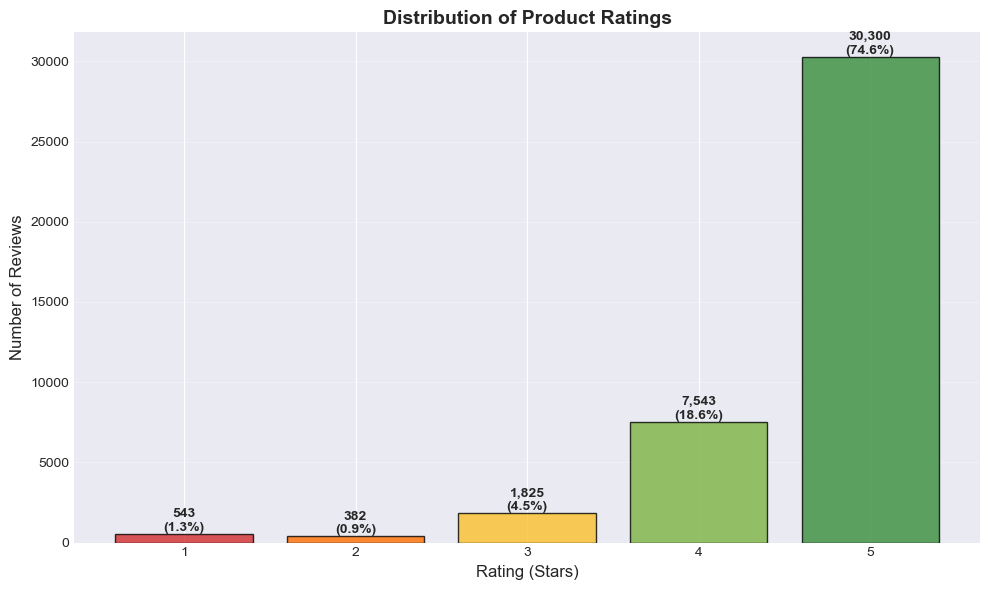


INTERPRETATION:
• Rating 5 dominates: 30,300 reviews (74.6%)
• Highly imbalanced dataset - positive bias
• Low ratings (1-2): 925 reviews (2.3%)
• Challenge: Model may be biased toward positive class
• Solution: Stratified splitting + class weighting in models


In [10]:
# Rating distribution
fig, ax = plt.subplots(figsize=(10, 6))
rating_counts = df_clean['rating'].value_counts().sort_index()
bars = ax.bar(rating_counts.index, rating_counts.values, color=['#d32f2f', '#ff6f00', '#fbc02d', '#7cb342', '#388e3c'], edgecolor='black', alpha=0.8)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(df_clean)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Rating (Stars)', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.set_title('Distribution of Product Ratings', fontsize=14, fontweight='bold')
ax.set_xticks([1, 2, 3, 4, 5])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print(f"• Rating 5 dominates: {rating_counts[5]:,} reviews ({rating_counts[5]/len(df_clean)*100:.1f}%)")
print(f"• Highly imbalanced dataset - positive bias")
print(f"• Low ratings (1-2): {rating_counts[1] + rating_counts[2]:,} reviews ({(rating_counts[1] + rating_counts[2])/len(df_clean)*100:.1f}%)")
print(f"• Challenge: Model may be biased toward positive class")
print(f"• Solution: Stratified splitting + class weighting in models")

# 4. Label Engineering Strategy

### Labeling Rules

| Label | Criteria | Keywords | Example |
|-------|----------|----------|---------|
| **Kritik** | Rating ≤ 2 OR negative keywords | tidak sesuai, rusak, buruk, kecewa, salah, cacat, jelek | "Barang rusak dan tidak sesuai" |
| **Saran** | Contains suggestion keywords | saran, sebaiknya, harap, bisa, kalau, mungkin, tolong | "Bagus tapi sebaiknya di-packing lebih rapi" |
| **Pujian** | Rating = 5 AND positive keywords | bagus, mantap, cepat, puas, recommended, oke, baik, sempurna | "Barang bagus dan pengiriman cepat!" |
| **Informasi/Netral** | Rating 3-4, no strong sentiment | sudah sampai, terima, diterima | "Barang sudah diterima dengan baik" |
| **Lainnya** | Very short text (< 3 words) OR irrelevant | - | "ok", ".", "thanks" |

### Justification

This approach is based on:
1. **Aspect-Based Sentiment Analysis** (ABSA) principles - separating feedback type from polarity
2. **Multi-criteria decision making** - not relying solely on ratings
3. **Domain knowledge** - understanding Indonesian e-commerce review patterns
4. **Pragmatic balance** - interpretable rules + sufficient coverage

In [11]:
# Implement label assignment function
def assign_custom_label(row):
    text = str(row['text']).lower()
    rating = row['rating']
    word_count = len(text.split())
    
    # Define keyword lists
    kritik_keywords = [    
        'tidak', 'kecewa', 'buruk', 'rusak', 'jelek', 'mengecewakan', 'parah',
        'salah', 'beda', 'palsu', 'hancur', 'pecah', 'cacat', 'reject', 'bau',
        'kotor', 'bekas', 'lambat', 'lama sekali', 'gak', 'ga ', 'ngga',
        'zonk', 'rugi', 'marah', 'kesal', 'buat kecewa', 'payah', 
        'tidak sesuai', 'beda', 'berbeda'
    ]
    
    saran_keywords = [
        'sebaiknya', 'seharusnya', 'lebih baik', 'harap', 'tolong', 
        'coba', 'saran', 'usul', 'minta', 'mohon', 'kalau bisa',
        'ditingkatkan', 'diperbaiki', 'perlu', 'harus', 'jangan',
        'bisa', 'kalau', 'mungkin', 'tolong', 'lebih baik', 
        'akan lebih'
    ]
    
    pujian_keywords = [
        'bagus', 'mantap', 'puas', 'senang', 'suka', 'recomended', 'recommended',
        'memuaskan', 'terbaik', 'sukses', 'jos', 'top', 'makasih', 'terima kasih',
        'thanks', 'good', 'baik', 'oke', 'ok', 'keren', 'sempurna', 'perfect',
        'super', 'amazing', 'love', 'excellent', 'cepat', 'mantab', 'rekomendasi',
        'sesuai',  'berkualitas'
    ]
    
    netral_keywords = [
        'sudah sampai', 'terima', 'diterima', 'sampai', 'sudah'
    ]
    
    # Rule 1: Very short reviews → Lainnya
    if word_count < 3:
        return 'Lainnya'
    
    # Rule 2: Low ratings → Kritik
    if rating <= 2:
        return 'Kritik'
    
    # Rule 3: Check for suggestions (highest priority after kritik)
    if any(keyword in text for keyword in saran_keywords):
        return 'Saran'
    
    # Rule 4: Check for strong criticism keywords even in mid ratings
    kritik_count = sum(1 for keyword in kritik_keywords if keyword in text)
    if kritik_count >= 2:  # Multiple negative keywords
        return 'Kritik'
    
    # Rule 5: High rating + positive keywords → Pujian
    if rating == 5:
        if any(keyword in text for keyword in pujian_keywords):
            return 'Pujian'
        # Even without keywords, rating 5 is usually praise
        return 'Pujian'
    
    # Rule 6: Rating 4 + positive keywords → Pujian
    if rating == 4 and any(keyword in text for keyword in pujian_keywords):
        return 'Pujian'
    
    # Rule 7: Neutral/informational
    if any(keyword in text for keyword in netral_keywords):
        return 'Informasi/Netral'
    
    # Default: Based on rating
    if rating >= 4:
        return 'Pujian'
    else:
        return 'Informasi/Netral'

# Apply labeling function
print("Assigning custom labels to all reviews...")
df_clean['label'] = df_clean.apply(assign_custom_label, axis=1)
print("✓ Labeling complete!")

Assigning custom labels to all reviews...
✓ Labeling complete!


LABEL DISTRIBUTION
Pujian                 30,699 (75.63%)
Saran                   3,189 ( 7.86%)
Lainnya                 3,074 ( 7.57%)
Kritik                  1,998 ( 4.92%)
Informasi/Netral        1,633 ( 4.02%)
----------------------------------------------------------------------
TOTAL                  40,593 (100.00%)


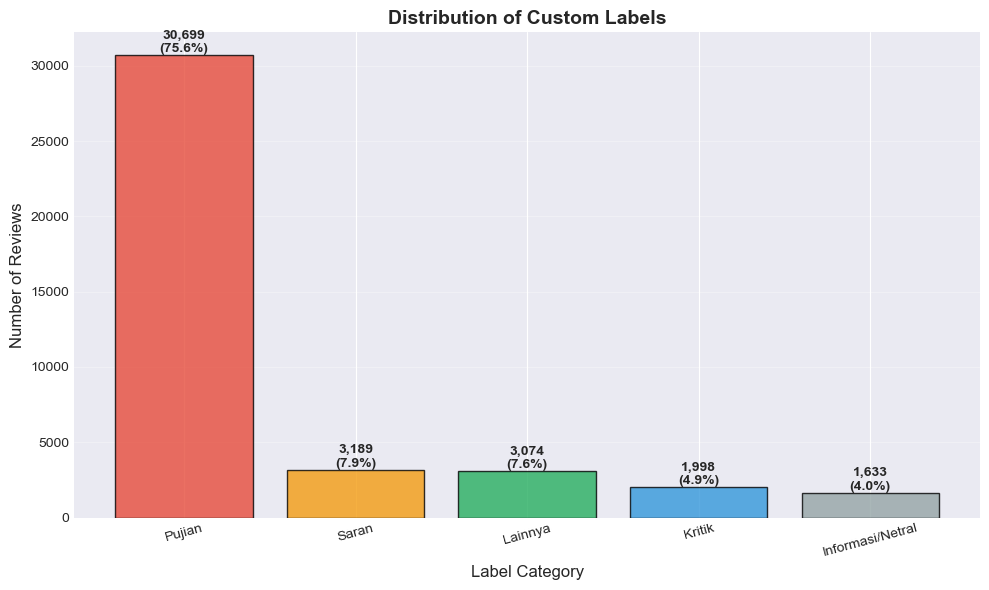


INTERPRETATION:
• Label distribution reflects natural e-commerce review patterns
• 'Pujian' dominates (positive bias typical in online marketplaces)
• 'Kritik' and 'Saran' are minority classes (important for business!)
• Class imbalance requires stratified sampling and careful evaluation
• Consider class weights during model training


In [12]:
# Analyze label distribution
label_counts = df_clean['label'].value_counts()

print("=" * 70)
print("LABEL DISTRIBUTION")
print("=" * 70)
for label, count in label_counts.items():
    percentage = (count / len(df_clean)) * 100
    print(f"{label:<20} {count:>8,} ({percentage:>5.2f}%)")
print("-" * 70)
print(f"{'TOTAL':<20} {len(df_clean):>8,} (100.00%)")
print("=" * 70)

# Visualize label distribution
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c', '#f39c12', '#27ae60', '#3498db', '#95a5a6']
bars = ax.bar(label_counts.index, label_counts.values, color=colors, edgecolor='black', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(df_clean)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Label Category', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.set_title('Distribution of Custom Labels', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=15)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("• Label distribution reflects natural e-commerce review patterns")
print("• 'Pujian' dominates (positive bias typical in online marketplaces)")
print("• 'Kritik' and 'Saran' are minority classes (important for business!)")
print("• Class imbalance requires stratified sampling and careful evaluation")
print("• Consider class weights during model training")

# 5. Text Preprocessing Pipeline

Indonesian text preprocessing requires specific handling:
1. **Case folding**: Standardize to lowercase
2. **Noise removal**: HTML entities, URLs, numbers, special characters
3. **Tokenization**: Split into words
4. **Stopword removal**: Remove Indonesian common words (Sastrawi)
5. **Stemming**: Reduce words to root form (Sastrawi stemmer for Indonesian)

Each step reduces noise and improves model focus on meaningful content.

In [ ]:
# Initialize Indonesian NLP tools
print("Initializing Indonesian NLP tools...")

# Stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# Stopwords
stopword_factory = StopWordRemoverFactory()
indonesian_stopwords = stopword_factory.get_stop_words()
# Add custom stopwords specific to e-commerce reviews
custom_stopwords = ['gan', 'agan', 'sist', 'ya', 'sih', 'deh', 'dong', 'kok', 'lho']
indonesian_stopwords = set(list(indonesian_stopwords) + custom_stopwords)

print(f"✓ Stemmer initialized")
print(f"✓ Stopwords loaded: {len(indonesian_stopwords)} words")

def preprocess_text(text):
    # 1. Case folding
    text = text.lower()
    
    # 2. Remove HTML entities
    text = re.sub(r'&[a-z]+;', ' ', text)
    text = re.sub(r'&#\d+;', ' ', text)
    
    # 3. Remove URLs
    text = re.sub(r'http\S+|www\S+', ' ', text)
    
    # 4. Remove numbers
    text = re.sub(r'\d+', ' ', text)
    
    # 5. Remove punctuation and special characters (keep Indonesian letters)
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 6. Tokenization
    tokens = word_tokenize(text)
    
    # 7. Remove stopwords
    tokens = [word for word in tokens if word not in indonesian_stopwords and len(word) > 2]
    
    # 8. Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    # 9. Rejoin
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

print("\n✓ Preprocessing function defined")

Initializing Indonesian NLP tools...
✓ Stemmer initialized
✓ Stopwords loaded: 131 words

✓ Preprocessing function defined


In [14]:
# Apply preprocessing with progress bar
from tqdm.auto import tqdm
tqdm.pandas()

print("Preprocessing all reviews...")
print("This may take a few minutes...\n")

# Apply preprocessing
df_clean['text_preprocessed'] = df_clean['text'].progress_apply(preprocess_text)

# Remove rows where preprocessing resulted in empty text
df_clean = df_clean[df_clean['text_preprocessed'].str.len() > 0].copy()

print(f"\n✓ Preprocessing complete!")
print(f"✓ Final dataset size: {len(df_clean):,} reviews")

Preprocessing all reviews...
This may take a few minutes...



  0%|          | 0/40593 [00:00<?, ?it/s]


✓ Preprocessing complete!
✓ Final dataset size: 40,223 reviews


In [18]:
# Show before/after preprocessing examples
print("=" * 100)
print("BEFORE vs AFTER PREPROCESSING (5 Examples)")
print("=" * 100)

sample_indices = df_clean.sample(5, random_state=RANDOM_STATE).index

for i, idx in enumerate(sample_indices, 1):
    original = df_clean.loc[idx, 'text']
    preprocessed = df_clean.loc[idx, 'text_preprocessed']
    label = df_clean.loc[idx, 'label']
    
    print(f"\n[Example {i}] Label: {label}")
    print(f"BEFORE:  {original}")
    print(f"AFTER:   {preprocessed}")
    print("-" * 100)

print("\n✓ Preprocessing successfully removed noise, standardized format, and reduced to root words")

BEFORE vs AFTER PREPROCESSING (5 Examples)

[Example 1] Label: Saran
BEFORE:  Barang bagus dan kemasannya juga bagus, terima kasih tokopedia dan toko yg menjualnya, saya puas dan barangnya sesuai harapan saya terima kasih dan sukses selalu
AFTER:   barang bagus kemas bagus terima kasih tokopedia toko jual puas barang sesuai harap terima kasih sukses selalu
----------------------------------------------------------------------------------------------------

[Example 2] Label: Pujian
BEFORE:  Simple, bentuk elegan serta harga yg sangat memuaskan!
AFTER:   simple bentuk elegan harga sangat muas
----------------------------------------------------------------------------------------------------

[Example 3] Label: Pujian
BEFORE:  Sesuai, murah dan kondisi bagus
AFTER:   sesuai murah kondisi bagus
----------------------------------------------------------------------------------------------------

[Example 4] Label: Pujian
BEFORE:  Barang terima baik dan fast respon. Recomended
AFTER:   bar

# 6. Feature Extraction & Train/Test Split

## 6.1 Feature Extraction Strategy

We will use TWO feature representations for fair comparison:

### 1. TF-IDF (Term Frequency-Inverse Document Frequency)
- **Purpose**: Classical ML baseline (SVM)
- **Advantages**: Fast, interpretable, works well with linear models
- **Settings**: max_features=5000, ngram_range=(1,2)
- **Use case**: Shallow learning comparison

### 2. IndoBERT Embeddings
- **Purpose**: Deep learning with contextual understanding
- **Advantages**: Captures semantic meaning, handles Indonesian morphology
- **Models**: indobert-base-p1 and indobert-base-p2
- **Use case**: State-of-the-art Indonesian NLP

## 6.2 Data Splitting Strategy

- **70% Training**: Model learning
- **15% Validation**: Hyperparameter tuning
- **15% Test**: Final evaluation (unseen data)
- **Stratified**: Maintains class distribution across splits

In [19]:
# Prepare features and labels
X = df_clean['text_preprocessed'].values
y = df_clean['label'].values
X_original = df_clean['text'].values  # Keep original text for IndoBERT

# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("=" * 70)
print("DATASET PREPARATION")
print("=" * 70)
print(f"Total samples: {len(X):,}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"\nClass mapping:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"  {idx}: {label}")
print("=" * 70)

# Split into train, validation, and test sets (70-15-15)
# Keep both preprocessed and original text versions
# First split: 70% train, 30% temp
X_train, X_temp, X_train_orig, X_temp_orig, y_train, y_temp = train_test_split(
    X, X_original, y_encoded, test_size=0.30, random_state=RANDOM_STATE, stratify=y_encoded
)

# Second split: 15% validation, 15% test (from 30% temp)
X_val, X_test, X_val_orig, X_test_orig, y_val, y_test = train_test_split(
    X_temp, X_temp_orig, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"\n✓ Data split complete:")
print(f"  Training set:   {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation set: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test set:       {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

DATASET PREPARATION
Total samples: 40,223
Number of classes: 5

Class mapping:
  0: Informasi/Netral
  1: Kritik
  2: Lainnya
  3: Pujian
  4: Saran

✓ Data split complete:
  Training set:   28,156 samples (70.0%)
  Validation set: 6,033 samples (15.0%)
  Test set:       6,034 samples (15.0%)


In [20]:
# Create TF-IDF features
print("\nExtracting TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"✓ TF-IDF features extracted")
print(f"  Feature matrix shape (train): {X_train_tfidf.shape}")
print(f"  Vocabulary size: {len(tfidf_vectorizer.vocabulary_):,}")
print(f"  Sparsity: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))*100:.2f}%")


Extracting TF-IDF features...
✓ TF-IDF features extracted
  Feature matrix shape (train): (28156, 5000)
  Vocabulary size: 5,000
  Sparsity: 99.83%


# 7. Modeling

## 7.1 Overview

We will train and compare **4 models** in two phases:

**Phase 1: Baseline Models** (Default hyperparameters)
- SVM Baseline
- IndoBERT-p2 Baseline

**Phase 2: Tuned Models** (Optimized hyperparameters)
- SVM Tuned
- IndoBERT-p2 Tuned

In [21]:
# Create models directory
import os
os.makedirs('models', exist_ok=True)
print("✓ Models directory created")

✓ Models directory created


## 7.2 SVM Baseline Model

**Approach**: Linear SVM with TF-IDF features  
**Hyperparameters**: Default (C=1.0)  
**Training Time**: ~30 seconds  

Linear SVM is a strong baseline for text classification:
- Fast training and inference
- Interpretable (feature weights)
- Works well with high-dimensional sparse features (TF-IDF)

In [22]:
# Train SVM Baseline
print("=" * 70)
print("TRAINING SVM BASELINE MODEL")
print("=" * 70)

start_time = time.time()

svm_baseline = LinearSVC(C=1.0, random_state=RANDOM_STATE, max_iter=2000, class_weight='balanced')
svm_baseline.fit(X_train_tfidf, y_train)

training_time = time.time() - start_time

# Evaluate on validation set
y_val_pred_svm = svm_baseline.predict(X_val_tfidf)

svm_baseline_metrics = {
    'accuracy': accuracy_score(y_val, y_val_pred_svm),
    'precision': precision_score(y_val, y_val_pred_svm, average='weighted', zero_division=0),
    'recall': recall_score(y_val, y_val_pred_svm, average='weighted', zero_division=0),
    'f1_weighted': f1_score(y_val, y_val_pred_svm, average='weighted', zero_division=0),
    'f1_macro': f1_score(y_val, y_val_pred_svm, average='macro', zero_division=0)
}

# Save model
joblib.dump(svm_baseline, 'models/svm_baseline.pkl')
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')

print(f"\n✓ Training complete in {training_time:.2f} seconds")
print(f"\nVALIDATION SET PERFORMANCE:")
print(f"  Accuracy:        {svm_baseline_metrics['accuracy']:.4f}")
print(f"  Precision:       {svm_baseline_metrics['precision']:.4f}")
print(f"  Recall:          {svm_baseline_metrics['recall']:.4f}")
print(f"  F1-Score (weighted): {svm_baseline_metrics['f1_weighted']:.4f}")
print(f"  F1-Score (macro):    {svm_baseline_metrics['f1_macro']:.4f}")
print(f"\n✓ Model saved to: models/svm_baseline.pkl")
print("=" * 70)

TRAINING SVM BASELINE MODEL

✓ Training complete in 0.39 seconds

VALIDATION SET PERFORMANCE:
  Accuracy:        0.8241
  Precision:       0.8450
  Recall:          0.8241
  F1-Score (weighted): 0.8327
  F1-Score (macro):    0.6323

✓ Model saved to: models/svm_baseline.pkl


## 7.3 SVM Tuned Model

**Approach**: Grid Search for optimal hyperparameter C  
**Search Space**: C ∈ [0.1, 1.0, 10.0, 100.0]  
**Cross-Validation**: 3-fold stratified CV  

The C parameter controls the trade-off between:
- **Low C**: Larger margin, more regularization (simpler model)
- **High C**: Smaller margin, less regularization (complex model)

In [23]:
# Train SVM Tuned with GridSearch
print("=" * 70)
print("TUNING SVM HYPERPARAMETERS")
print("=" * 70)

start_time = time.time()

param_grid = {'C': [0.1, 1.0, 10.0, 100.0]}

grid_search = GridSearchCV(
    LinearSVC(random_state=RANDOM_STATE, max_iter=2000, class_weight='balanced'),
    param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_tfidf, y_train)

training_time = time.time() - start_time

svm_tuned = grid_search.best_estimator_

print(f"\n✓ Best hyperparameters: {grid_search.best_params_}")
print(f"✓ Best CV F1-Score: {grid_search.best_score_:.4f}")

# Evaluate on validation set
y_val_pred_svm_tuned = svm_tuned.predict(X_val_tfidf)

svm_tuned_metrics = {
    'accuracy': accuracy_score(y_val, y_val_pred_svm_tuned),
    'precision': precision_score(y_val, y_val_pred_svm_tuned, average='weighted', zero_division=0),
    'recall': recall_score(y_val, y_val_pred_svm_tuned, average='weighted', zero_division=0),
    'f1_weighted': f1_score(y_val, y_val_pred_svm_tuned, average='weighted', zero_division=0),
    'f1_macro': f1_score(y_val, y_val_pred_svm_tuned, average='macro', zero_division=0)
}

# Save model
joblib.dump(svm_tuned, 'models/svm_tuned.pkl')

print(f"\n✓ Tuning complete in {training_time:.2f} seconds")
print(f"\nVALIDATION SET PERFORMANCE:")
print(f"  Accuracy:        {svm_tuned_metrics['accuracy']:.4f}")
print(f"  Precision:       {svm_tuned_metrics['precision']:.4f}")
print(f"  Recall:          {svm_tuned_metrics['recall']:.4f}")
print(f"  F1-Score (weighted): {svm_tuned_metrics['f1_weighted']:.4f}")
print(f"  F1-Score (macro):    {svm_tuned_metrics['f1_macro']:.4f}")
print(f"\nIMPROVEMENT:")
print(f"  F1 Baseline: {svm_baseline_metrics['f1_weighted']:.4f}")
print(f"  F1 Tuned:    {svm_tuned_metrics['f1_weighted']:.4f}")
print(f"  Gain:        {(svm_tuned_metrics['f1_weighted'] - svm_baseline_metrics['f1_weighted']):.4f} ({((svm_tuned_metrics['f1_weighted'] - svm_baseline_metrics['f1_weighted'])/svm_baseline_metrics['f1_weighted']*100):+.2f}%)")
print(f"\n✓ Model saved to: models/svm_tuned.pkl")
print("=" * 70)

TUNING SVM HYPERPARAMETERS
Fitting 3 folds for each of 4 candidates, totalling 12 fits

✓ Best hyperparameters: {'C': 0.1}
✓ Best CV F1-Score: 0.8363

✓ Tuning complete in 5.09 seconds

VALIDATION SET PERFORMANCE:
  Accuracy:        0.8318
  Precision:       0.8449
  Recall:          0.8318
  F1-Score (weighted): 0.8366
  F1-Score (macro):    0.6317

IMPROVEMENT:
  F1 Baseline: 0.8327
  F1 Tuned:    0.8366
  Gain:        0.0039 (+0.47%)

✓ Model saved to: models/svm_tuned.pkl


## 7.4 IndoBERT Models - Setup

**Models**: 
- `indobenchmark/indobert-base-p2` 

**Why IndoBERT p2?**
- Optimized for Indonesian language (including slang & informal text)
- Better context and sentiment understanding than IndoBERT v1
- Strong performance for multiclass classification on Tokopedia reviews

**Training Strategy**:
- Use Hugging Face Transformers library
- Fine-tune last layers for classification
- GPU acceleration (if available)
- Early stopping to prevent overfitting

In [24]:
# Import transformers (minimal imports to avoid conflicts)
# Disable TensorFlow completely
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['USE_TF'] = 'NO'

# Import only what we need - avoid Trainer API
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

print("✓ Transformers library imported successfully")
print(f"✓ Device: {device}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

✓ Transformers library imported successfully
✓ Device: cuda:0
✓ CUDA available: True
✓ GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [25]:
# Prepare datasets for IndoBERT (using original text, not preprocessed)
# IndoBERT has its own tokenizer and handles preprocessing internally

# The original text splits were created during train_test_split
X_train_text = X_train_orig
X_val_text = X_val_orig
X_test_text = X_test_orig

# Verify alignment
print("Dataset preparation for IndoBERT:")
print(f"  Train: {len(X_train_text)} samples (labels: {len(y_train)})")
print(f"  Val:   {len(X_val_text)} samples (labels: {len(y_val)})")
print(f"  Test:  {len(X_test_text)} samples (labels: {len(y_test)})")

# Verify sizes match
assert len(X_train_text) == len(y_train), f"Train size mismatch: {len(X_train_text)} vs {len(y_train)}"
assert len(X_val_text) == len(y_val), f"Val size mismatch: {len(X_val_text)} vs {len(y_val)}"
assert len(X_test_text) == len(y_test), f"Test size mismatch: {len(X_test_text)} vs {len(y_test)}"

print("✓ Text datasets ready for tokenization")

Dataset preparation for IndoBERT:
  Train: 28156 samples (labels: 28156)
  Val:   6033 samples (labels: 6033)
  Test:  6034 samples (labels: 6034)
✓ Text datasets ready for tokenization


## 7.5 IndoBERT-p2 Baseline

**Model**: `indobenchmark/indobert-base-p2`  
**Hyperparameters** (Baseline):
- Learning rate: 2e-5
- Batch size: 16
- Epochs: 3
- Max length: 128 tokens

**Expected Training Time**:
- With GPU: ~20-30 minutes
- With CPU: ~2-4 hours (much slower!)

In [27]:
# Train IndoBERT-p2 Baseline (Manual PyTorch Training)
print("=" * 70)
print("TRAINING INDOBERT-P2 BASELINE")
print("=" * 70)

model_name = "indobenchmark/indobert-base-p2"

# Load tokenizer and model
print("Loading model and tokenizer...")
tokenizer_p2 = AutoTokenizer.from_pretrained(model_name)
model_p2_base = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    ignore_mismatched_sizes=True
).to(device)

print(f"✓ Model loaded: {model_name}")
print(f"✓ Model on device: {next(model_p2_base.parameters()).device}")

# Tokenize datasets
print("Tokenizing datasets...")
train_encodings = tokenizer_p2(list(X_train_text), truncation=True, padding=True, max_length=128, return_tensors='pt')
val_encodings = tokenizer_p2(list(X_val_text), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Create PyTorch datasets (ensure labels are Long type for CrossEntropyLoss)
train_dataset = TensorDataset(
    train_encodings['input_ids'], 
    train_encodings['attention_mask'], 
    torch.tensor(y_train, dtype=torch.long)
)
val_dataset = TensorDataset(
    val_encodings['input_ids'], 
    val_encodings['attention_mask'], 
    torch.tensor(y_val, dtype=torch.long)
)

print("✓ Datasets tokenized")

# Hyperparameters
batch_size = 16
learning_rate = 2e-5
num_epochs = 3
weight_decay = 0.01

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Optimizer and scheduler
optimizer = AdamW(model_p2_base.parameters(), lr=learning_rate, weight_decay=weight_decay)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Clear GPU cache before training
torch.cuda.empty_cache()

print("\nStarting training...")
print(f"Batch size: {batch_size}, Learning rate: {learning_rate}, Epochs: {num_epochs}")
print(f"Total training steps: {total_steps}")
print("-" * 70)

# Training loop with mixed precision
start_time = time.time()
best_f1 = 0
model_p2_base.train()

# Initialize GradScaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    epoch_loss = 0
    model_p2_base.train()
    
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        optimizer.zero_grad()
        
        # Mixed precision training
        with torch.cuda.amp.autocast():
            outputs = model_p2_base(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    
    # Validation
    model_p2_base.eval()
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model_p2_base(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1_weighted = f1_score(val_labels, val_preds, average='weighted', zero_division=0)
    val_f1_macro = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    
    print(f"\nEpoch {epoch+1}: Loss={avg_train_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1_weighted:.4f}")
    
    # Save best model
    if val_f1_weighted > best_f1:
        best_f1 = val_f1_weighted
        os.makedirs('./models/indobert_p2_baseline', exist_ok=True)
        
        # Save model properly - save full model not just state_dict
        model_p2_base.save_pretrained('./models/indobert_p2_baseline')
        tokenizer_p2.save_pretrained('./models/indobert_p2_baseline')
        print(f"✓ Best model saved (F1={best_f1:.4f})")

training_time = time.time() - start_time

# Final evaluation with best model
model_p2_base = AutoModelForSequenceClassification.from_pretrained('./models/indobert_p2_baseline').to(device)
model_p2_base.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model_p2_base(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

final_acc = accuracy_score(val_labels, val_preds)
final_f1_weighted = f1_score(val_labels, val_preds, average='weighted', zero_division=0)
final_f1_macro = f1_score(val_labels, val_preds, average='macro', zero_division=0)

print("\n" + "=" * 70)
print(f"✓ Training complete in {training_time/60:.2f} minutes ({training_time:.1f} seconds)")
print(f"\nVALIDATION SET PERFORMANCE (Best Model):")
print(f"  Accuracy:    {final_acc:.4f}")
print(f"  F1-weighted: {final_f1_weighted:.4f}")
print(f"  F1-macro:    {final_f1_macro:.4f}")
print(f"\n✓ Model saved to: models/indobert_p2_baseline/")
print("=" * 70)

TRAINING INDOBERT-P2 BASELINE
Loading model and tokenizer...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded: indobenchmark/indobert-base-p2
✓ Model on device: cuda:0
Tokenizing datasets...
✓ Datasets tokenized

Starting training...
Batch size: 16, Learning rate: 2e-05, Epochs: 3
Total training steps: 5280
----------------------------------------------------------------------


Epoch 1/3:   0%|          | 0/1760 [00:00<?, ?it/s]

Validating:   0%|          | 0/378 [00:00<?, ?it/s]


Epoch 1: Loss=0.3088, Val Acc=0.9209, Val F1=0.9107
✓ Best model saved (F1=0.9107)


Epoch 2/3:   0%|          | 0/1760 [00:00<?, ?it/s]

Validating:   0%|          | 0/378 [00:00<?, ?it/s]


Epoch 2: Loss=0.2016, Val Acc=0.9266, Val F1=0.9110
✓ Best model saved (F1=0.9110)


Epoch 3/3:   0%|          | 0/1760 [00:00<?, ?it/s]

Validating:   0%|          | 0/378 [00:00<?, ?it/s]


Epoch 3: Loss=0.1393, Val Acc=0.9257, Val F1=0.9191
✓ Best model saved (F1=0.9191)

✓ Training complete in 18.98 minutes (1138.8 seconds)

VALIDATION SET PERFORMANCE (Best Model):
  Accuracy:    0.9257
  F1-weighted: 0.9191
  F1-macro:    0.7751

✓ Model saved to: models/indobert_p2_baseline/


## 7.6 IndoBERT-p2 Tuned

**Approach**: Hyperparameter search for learning rate and epochs  
**Search Space**:
- Learning rate: 3e-5
- Epochs:  4

**Strategy**: Train with each combination and select best based on validation F1-score.

In [28]:
# Train IndoBERT-p2 Tuned (Manual PyTorch Training)
print("=" * 70)
print("TRAINING INDOBERT-P2 TUNED")
print("=" * 70)

model_name = "indobenchmark/indobert-base-p2"

# Load tokenizer and model
print("Loading model and tokenizer...")
model_p2_tuned = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    ignore_mismatched_sizes=True
).to(device)

print(f"✓ Model loaded: {model_name}")
print(f"✓ Model on device: {next(model_p2_tuned.parameters()).device}")

# Tokenize datasets (reuse from baseline)
print("✓ Datasets tokenized (reusing from baseline)")

# Hyperparameters
batch_size = 16
learning_rate = 3e-5
num_epochs = 4
weight_decay = 0.01

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Optimizer and scheduler
optimizer = AdamW(model_p2_tuned.parameters(), lr=learning_rate, weight_decay=weight_decay)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Clear GPU cache before training
torch.cuda.empty_cache()

print("\nStarting training...")
print(f"Batch size: {batch_size}, Learning rate: {learning_rate}, Epochs: {num_epochs}")
print(f"Total training steps: {total_steps}")
print("-" * 70)

# Training loop with mixed precision
start_time = time.time()
best_f1 = 0
model_p2_tuned.train()

# Initialize GradScaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    epoch_loss = 0
    model_p2_tuned.train()
    
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        optimizer.zero_grad()
        
        # Mixed precision training
        with torch.cuda.amp.autocast():
            outputs = model_p2_tuned(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    
    # Validation
    model_p2_tuned.eval()
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model_p2_tuned(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1_weighted = f1_score(val_labels, val_preds, average='weighted', zero_division=0)
    val_f1_macro = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    
    print(f"\nEpoch {epoch+1}: Loss={avg_train_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1_weighted:.4f}")
    
    # Save best model
    if val_f1_weighted > best_f1:
        best_f1 = val_f1_weighted
        os.makedirs('./models/indobert_p2_tuned', exist_ok=True)
        
        # Save model properly - save full model not just state_dict
        model_p2_tuned.save_pretrained('./models/indobert_p2_tuned')
        tokenizer_p2.save_pretrained('./models/indobert_p2_tuned')
        print(f"✓ Best model saved (F1={best_f1:.4f})")

training_time = time.time() - start_time

# Final evaluation with best model
model_p2_tuned = AutoModelForSequenceClassification.from_pretrained('./models/indobert_p2_tuned').to(device)
model_p2_tuned.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model_p2_tuned(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

final_acc = accuracy_score(val_labels, val_preds)
final_f1_weighted = f1_score(val_labels, val_preds, average='weighted', zero_division=0)
final_f1_macro = f1_score(val_labels, val_preds, average='macro', zero_division=0)

print("\n" + "=" * 70)
print(f"✓ Training complete in {training_time/60:.2f} minutes ({training_time:.1f} seconds)")
print(f"\nVALIDATION SET PERFORMANCE (Best Model):")
print(f"  Accuracy:    {final_acc:.4f}")
print(f"  F1-weighted: {final_f1_weighted:.4f}")
print(f"  F1-macro:    {final_f1_macro:.4f}")
print(f"\n✓ Model saved to: models/indobert_p2_tuned/")
print("=" * 70)

TRAINING INDOBERT-P2 TUNED
Loading model and tokenizer...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded: indobenchmark/indobert-base-p2
✓ Model on device: cuda:0
✓ Datasets tokenized (reusing from baseline)

Starting training...
Batch size: 16, Learning rate: 3e-05, Epochs: 4
Total training steps: 7040
----------------------------------------------------------------------


Epoch 1/4:   0%|          | 0/1760 [00:00<?, ?it/s]

Validating:   0%|          | 0/378 [00:00<?, ?it/s]


Epoch 1: Loss=0.3085, Val Acc=0.9223, Val F1=0.9008
✓ Best model saved (F1=0.9008)


Epoch 2/4:   0%|          | 0/1760 [00:00<?, ?it/s]

Validating:   0%|          | 0/378 [00:00<?, ?it/s]


Epoch 2: Loss=0.2100, Val Acc=0.9201, Val F1=0.9151
✓ Best model saved (F1=0.9151)


Epoch 3/4:   0%|          | 0/1760 [00:00<?, ?it/s]

Validating:   0%|          | 0/378 [00:00<?, ?it/s]


Epoch 3: Loss=0.1474, Val Acc=0.9281, Val F1=0.9214
✓ Best model saved (F1=0.9214)


Epoch 4/4:   0%|          | 0/1760 [00:00<?, ?it/s]

Validating:   0%|          | 0/378 [00:00<?, ?it/s]


Epoch 4: Loss=0.0937, Val Acc=0.9259, Val F1=0.9187

✓ Training complete in 25.56 minutes (1533.8 seconds)

VALIDATION SET PERFORMANCE (Best Model):
  Accuracy:    0.9281
  F1-weighted: 0.9214
  F1-macro:    0.7786

✓ Model saved to: models/indobert_p2_tuned/


## 7.7 Handle Imbalance Dataset

**Approach**: using classweight 'balance'

### SVM Tuned dengan Class Weights (Explicit) - Handle Imbalanced Data

In [29]:
# Train SVM Tuned dengan Class Weights (Explicit Display)
print("=" * 70)
print("TUNING SVM WITH EXPLICIT CLASS WEIGHTS")
print("=" * 70)

from sklearn.utils.class_weight import compute_class_weight

# Display class weights (same computation as before)
class_weights_svm = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights_svm))

print("\nClass weights for tuned SVM:")
for label_idx, weight in class_weight_dict.items():
    label_name = label_encoder.classes_[label_idx]
    print(f"  {label_name:20s} (class {label_idx}): {weight:.4f}")

start_time = time.time()

param_grid = {'C': [0.1, 1.0, 10.0, 100.0]}

grid_search_balanced = GridSearchCV(
    LinearSVC(random_state=RANDOM_STATE, max_iter=2000, class_weight='balanced'),
    param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search_balanced.fit(X_train_tfidf, y_train)

training_time = time.time() - start_time

svm_tuned_balanced = grid_search_balanced.best_estimator_

print(f"\n✓ Best hyperparameters: {grid_search_balanced.best_params_}")
print(f"✓ Best CV F1-Score: {grid_search_balanced.best_score_:.4f}")

# Evaluate on validation set
y_val_pred_svm_tuned_balanced = svm_tuned_balanced.predict(X_val_tfidf)

svm_tuned_balanced_metrics = {
    'accuracy': accuracy_score(y_val, y_val_pred_svm_tuned_balanced),
    'precision': precision_score(y_val, y_val_pred_svm_tuned_balanced, average='weighted', zero_division=0),
    'recall': recall_score(y_val, y_val_pred_svm_tuned_balanced, average='weighted', zero_division=0),
    'f1_weighted': f1_score(y_val, y_val_pred_svm_tuned_balanced, average='weighted', zero_division=0),
    'f1_macro': f1_score(y_val, y_val_pred_svm_tuned_balanced, average='macro', zero_division=0)
}

# Per-class F1 scores
print("\nPer-class F1 scores:")
class_report = classification_report(y_val, y_val_pred_svm_tuned_balanced, target_names=label_encoder.classes_, output_dict=True)
for label_name in label_encoder.classes_:
    print(f"  {label_name:20s}: {class_report[label_name]['f1-score']:.4f}")

# Save model
joblib.dump(svm_tuned_balanced, 'models/svm_tuned_balanced.pkl')

print(f"\n✓ Tuning complete in {training_time:.2f} seconds")
print(f"\nVALIDATION SET PERFORMANCE:")
print(f"  Accuracy:            {svm_tuned_balanced_metrics['accuracy']:.4f}")
print(f"  Precision:           {svm_tuned_balanced_metrics['precision']:.4f}")
print(f"  Recall:              {svm_tuned_balanced_metrics['recall']:.4f}")
print(f"  F1-Score (weighted): {svm_tuned_balanced_metrics['f1_weighted']:.4f}")
print(f"  F1-Score (macro):    {svm_tuned_balanced_metrics['f1_macro']:.4f}")

# Compare with baseline
if 'svm_baseline_balanced_metrics' in locals():
    print(f"\nCOMPARISON WITH BASELINE (BALANCED):")
    print(f"  F1 Baseline: {svm_baseline_balanced_metrics['f1_weighted']:.4f}")
    print(f"  F1 Tuned:    {svm_tuned_balanced_metrics['f1_weighted']:.4f}")
    print(f"  Gain:        {(svm_tuned_balanced_metrics['f1_weighted'] - svm_baseline_balanced_metrics['f1_weighted']):.4f} ({((svm_tuned_balanced_metrics['f1_weighted'] - svm_baseline_balanced_metrics['f1_weighted'])/svm_baseline_balanced_metrics['f1_weighted']*100):+.2f}%)")

print(f"\n✓ Model saved to: models/svm_tuned_balanced.pkl")
print("=" * 70)

TUNING SVM WITH EXPLICIT CLASS WEIGHTS

Class weights for tuned SVM:
  Informasi/Netral     (class 0): 4.9267
  Kritik               (class 1): 4.0309
  Lainnya              (class 2): 2.9483
  Pujian               (class 3): 0.2622
  Saran                (class 4): 2.5229
Fitting 3 folds for each of 4 candidates, totalling 12 fits

✓ Best hyperparameters: {'C': 0.1}
✓ Best CV F1-Score: 0.8363

Per-class F1 scores:
  Informasi/Netral    : 0.2318
  Kritik              : 0.5556
  Lainnya             : 0.6932
  Pujian              : 0.9067
  Saran               : 0.7713

✓ Tuning complete in 6.61 seconds

VALIDATION SET PERFORMANCE:
  Accuracy:            0.8318
  Precision:           0.8449
  Recall:              0.8318
  F1-Score (weighted): 0.8366
  F1-Score (macro):    0.6317

✓ Model saved to: models/svm_tuned_balanced.pkl


### IndoBERT-p2 Tuned dengan Class Weights (Handle Imbalanced Data)

In [31]:
# Train IndoBERT-p2 Tuned dengan Class Weights
print("=" * 70)
print("TRAINING INDOBERT-P2 TUNED WITH CLASS WEIGHTS")
print("=" * 70)

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights (same as before)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Class weights: {class_weights}")
print(f"Class mapping: {dict(zip(label_encoder.classes_, class_weights.cpu().numpy()))}")

model_name = "indobenchmark/indobert-base-p2"

# Load tokenizer and model
print("\nLoading model and tokenizer...")
tokenizer_p2_tuned_balanced = AutoTokenizer.from_pretrained(model_name)
model_p2_tuned_balanced = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    ignore_mismatched_sizes=True
).to(device)

print(f"✓ Model loaded: {model_name}")

# Tokenize datasets
print("Tokenizing datasets...")
train_encodings_tuned = tokenizer_p2_tuned_balanced(list(X_train_text), truncation=True, padding=True, max_length=128, return_tensors='pt')
val_encodings_tuned = tokenizer_p2_tuned_balanced(list(X_val_text), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Create PyTorch datasets
train_dataset_tuned = TensorDataset(
    train_encodings_tuned['input_ids'], 
    train_encodings_tuned['attention_mask'], 
    torch.tensor(y_train, dtype=torch.long)
)
val_dataset_tuned = TensorDataset(
    val_encodings_tuned['input_ids'], 
    val_encodings_tuned['attention_mask'], 
    torch.tensor(y_val, dtype=torch.long)
)

print("✓ Datasets tokenized")

# Tuned hyperparameters
batch_size = 16
learning_rate = 3e-5
num_epochs = 4
weight_decay = 0.01

# Create data loaders
train_loader_tuned = DataLoader(train_dataset_tuned, batch_size=batch_size, shuffle=True)
val_loader_tuned = DataLoader(val_dataset_tuned, batch_size=batch_size)

# Optimizer and scheduler
optimizer_tuned = AdamW(model_p2_tuned_balanced.parameters(), lr=learning_rate, weight_decay=weight_decay)
total_steps = len(train_loader_tuned) * num_epochs
scheduler_tuned = get_linear_schedule_with_warmup(optimizer_tuned, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

# Custom loss function with class weights
loss_fn_tuned = torch.nn.CrossEntropyLoss(weight=class_weights)

# Clear GPU cache before training
torch.cuda.empty_cache()

print("\nStarting tuned training with class weights...")
print(f"Batch size: {batch_size}, Learning rate: {learning_rate}, Epochs: {num_epochs}")
print(f"Warmup steps: {int(0.1 * total_steps)}, Total steps: {total_steps}")
print("-" * 70)

# Training loop with mixed precision
start_time = time.time()
best_f1_tuned_balanced = 0
model_p2_tuned_balanced.train()

# Initialize GradScaler for mixed precision training
scaler_tuned = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0
    
    for batch_idx, batch in enumerate(tqdm(train_loader_tuned, desc=f"Training Epoch {epoch + 1}")):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        optimizer_tuned.zero_grad()
        
        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            outputs = model_p2_tuned_balanced(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn_tuned(outputs.logits, labels)  # Use custom loss with class weights
        
        # Backward pass with scaling
        scaler_tuned.scale(loss).backward()
        scaler_tuned.step(optimizer_tuned)
        scaler_tuned.update()
        scheduler_tuned.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader_tuned)
    
    # Validation
    model_p2_tuned_balanced.eval()
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader_tuned, desc=f"Validation Epoch {epoch + 1}"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            
            with torch.cuda.amp.autocast():
                outputs = model_p2_tuned_balanced(input_ids=input_ids, attention_mask=attention_mask)
            
            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)
    
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1_macro = f1_score(val_labels, val_preds, average='macro')
    val_f1_weighted = f1_score(val_labels, val_preds, average='weighted')
    
    print(f"Avg Train Loss: {avg_train_loss:.4f}")
    print(f"Val Accuracy: {val_acc:.4f}")
    print(f"Val F1 Macro: {val_f1_macro:.4f}")
    print(f"Val F1 Weighted: {val_f1_weighted:.4f}")
    
    # Save best model
    if val_f1_macro > best_f1_tuned_balanced:
        best_f1_tuned_balanced = val_f1_macro
        output_path = "models/indobert_p2_tuned_balanced"
        model_p2_tuned_balanced.save_pretrained(output_path)
        tokenizer_p2_tuned_balanced.save_pretrained(output_path)
        print(f"✓ Best model saved with F1 Macro: {best_f1_tuned_balanced:.4f}")
    
    model_p2_tuned_balanced.train()

training_time = time.time() - start_time
print("\n" + "=" * 70)
print(f"✓ Training completed in {training_time/60:.2f} minutes")
print(f"✓ Best validation F1 Macro: {best_f1_tuned_balanced:.4f}")
print("=" * 70)

TRAINING INDOBERT-P2 TUNED WITH CLASS WEIGHTS
Class weights: tensor([4.9267, 4.0309, 2.9483, 0.2622, 2.5229], device='cuda:0')
Class mapping: {'Informasi/Netral': 4.9266844, 'Kritik': 4.0309234, 'Lainnya': 2.9482722, 'Pujian': 0.2622334, 'Saran': 2.522939}

Loading model and tokenizer...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded: indobenchmark/indobert-base-p2
Tokenizing datasets...
✓ Datasets tokenized

Starting tuned training with class weights...
Batch size: 16, Learning rate: 3e-05, Epochs: 4
Warmup steps: 704, Total steps: 7040
----------------------------------------------------------------------

Epoch 1/4


Training Epoch 1:   0%|          | 0/1760 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/378 [00:00<?, ?it/s]

Avg Train Loss: 0.6958
Val Accuracy: 0.8846
Val F1 Macro: 0.7471
Val F1 Weighted: 0.8928
✓ Best model saved with F1 Macro: 0.7471

Epoch 2/4


Training Epoch 2:   0%|          | 0/1760 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/378 [00:00<?, ?it/s]

Avg Train Loss: 0.4361
Val Accuracy: 0.8548
Val F1 Macro: 0.7438
Val F1 Weighted: 0.8753

Epoch 3/4


Training Epoch 3:   0%|          | 0/1760 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/378 [00:00<?, ?it/s]

Avg Train Loss: 0.2985
Val Accuracy: 0.8371
Val F1 Macro: 0.7326
Val F1 Weighted: 0.8621

Epoch 4/4


Training Epoch 4:   0%|          | 0/1760 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/378 [00:00<?, ?it/s]

Avg Train Loss: 0.1855
Val Accuracy: 0.8664
Val F1 Macro: 0.7539
Val F1 Weighted: 0.8836
✓ Best model saved with F1 Macro: 0.7539

✓ Training completed in 498.51 minutes
✓ Best validation F1 Macro: 0.7539


# 8. Model Evaluation on Test Set

## 8.1 Overview

**Metrics**:
- Accuracy
- Precision (weighted & macro)
- Recall (weighted & macro)
- F1-Score (weighted & macro)
- Confusion Matrix
- Per-class performance

In [ ]:
print("=" * 70)
print("TEST SET EVALUATION - ALL MODELS")
print("=" * 70)

test_results = {}

# 1. SVM BASELINE
print("\n[1/6] Evaluating SVM Baseline...")
y_pred = svm_baseline.predict(X_test_tfidf)
test_results['SVM Baseline'] = {
    'predictions': y_pred,
    'accuracy': accuracy_score(y_test, y_pred),
    'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=0),
    'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=0),
    'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=0),
    'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0)
}
print(f"  Accuracy: {test_results['SVM Baseline']['accuracy']:.4f}")
print(f"  F1 (weighted): {test_results['SVM Baseline']['f1_weighted']:.4f}")

# 2. SVM TUNED
print("\n[2/6] Evaluating SVM Tuned...")
y_pred = svm_tuned.predict(X_test_tfidf)
test_results['SVM Tuned'] = {
    'predictions': y_pred,
    'accuracy': accuracy_score(y_test, y_pred),
    'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=0),
    'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=0),
    'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=0),
    'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0)
}
print(f"  Accuracy: {test_results['SVM Tuned']['accuracy']:.4f}")
print(f"  F1 (weighted): {test_results['SVM Tuned']['f1_weighted']:.4f}")

# 3. SVM TUNED BALANCED
if 'svm_tuned_balanced' in globals():
    print("\n[3/6] Evaluating SVM Tuned Balanced...")
    y_pred = svm_tuned_balanced.predict(X_test_tfidf)
    test_results['SVM Tuned Balanced'] = {
        'predictions': y_pred,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=0),
        'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0)
    }
    print(f"  Accuracy: {test_results['SVM Tuned Balanced']['accuracy']:.4f}")
    print(f"  F1 (weighted): {test_results['SVM Tuned Balanced']['f1_weighted']:.4f}")
else:
    print("\n[3/6] SVM Tuned Balanced not found, skipping...")

def eval_indobert(model_path, model_name):
    print(f"\n[{len(test_results) + 1}/6] Evaluating {model_name}...")
    
    # Check if model directory exists
    if not os.path.exists(model_path):
        print(f"  Model not found at {model_path}")
        print(f"  Skipping {model_name} evaluation")
        return
    
    try:
        # Load model directly using save_pretrained format
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
        model.eval()

        encodings = tokenizer(
            list(X_test_text),
            truncation=True,
            padding=True,
            max_length=128,
            return_tensors="pt"
        )

        dataset = TensorDataset(
            encodings["input_ids"],
            encodings["attention_mask"],
            torch.tensor(y_test, dtype=torch.long)
        )

        loader = DataLoader(dataset, batch_size=16)

        preds = []
        with torch.no_grad():
            for input_ids, attention_mask, _ in tqdm(loader, desc="  Testing", leave=False):
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

        preds = np.array(preds)

        test_results[model_name] = {
            'predictions': preds,
            'accuracy': accuracy_score(y_test, preds),
            'precision_weighted': precision_score(y_test, preds, average='weighted', zero_division=0),
            'recall_weighted': recall_score(y_test, preds, average='weighted', zero_division=0),
            'f1_weighted': f1_score(y_test, preds, average='weighted', zero_division=0),
            'f1_macro': f1_score(y_test, preds, average='macro', zero_division=0)
        }

        print(f"  Accuracy: {test_results[model_name]['accuracy']:.4f}")
        print(f"  F1 (weighted): {test_results[model_name]['f1_weighted']:.4f}")
        print(f"  ✓ Successfully evaluated {model_name}")
        
    except Exception as e:
        print(f"  Error evaluating {model_name}: {str(e)}")
        print(f"  Skipping {model_name}")

# 4. IndoBERT-p2 Baseline
eval_indobert("./models/indobert_p2_baseline", "IndoBERT-p2 Baseline")

# 5. IndoBERT-p2 Tuned
eval_indobert("./models/indobert_p2_tuned", "IndoBERT-p2 Tuned")

# 6. IndoBERT-p2 Tuned Balanced
eval_indobert("./models/indobert_p2_tuned_balanced", "IndoBERT-p2 Tuned Balanced")

print("\n" + "=" * 70)
print("✓ Evaluation complete for all models")
print(f"✓ Total models evaluated: {len(test_results)}")
print("=" * 70)

TEST SET EVALUATION - ALL MODELS

[1/6] Evaluating SVM Baseline...
  Accuracy: 0.8252
  F1 (weighted): 0.8347

[2/6] Evaluating SVM Tuned...
  Accuracy: 0.8334
  F1 (weighted): 0.8399

[3/6] Evaluating SVM Tuned Balanced...
  Accuracy: 0.8334
  F1 (weighted): 0.8399

[4/6] Evaluating IndoBERT-p2 Baseline...


  Testing:   0%|          | 0/378 [00:00<?, ?it/s]

  Accuracy: 0.9214
  F1 (weighted): 0.9143
  ✓ Successfully evaluated IndoBERT-p2 Baseline

[5/6] Evaluating IndoBERT-p2 Tuned...


  Testing:   0%|          | 0/378 [00:00<?, ?it/s]

  Accuracy: 0.9233
  F1 (weighted): 0.9170
  ✓ Successfully evaluated IndoBERT-p2 Tuned

[6/6] Evaluating IndoBERT-p2 Tuned Balanced...


  Testing:   0%|          | 0/378 [00:00<?, ?it/s]

  Accuracy: 0.8653
  F1 (weighted): 0.8822
  ✓ Successfully evaluated IndoBERT-p2 Tuned Balanced

✓ Evaluation complete for all models
✓ Total models evaluated: 6


## 8.2 Model Comparison Table

MODEL COMPARISON - TEST SET RESULTS
                     Model Accuracy Precision Recall F1 (weighted) F1 (macro)
              SVM Baseline   0.8252    0.8478 0.8252        0.8347     0.6341
                 SVM Tuned   0.8334    0.8496 0.8334        0.8399     0.6387
        SVM Tuned Balanced   0.8334    0.8496 0.8334        0.8399     0.6387
      IndoBERT-p2 Baseline   0.9214    0.9096 0.9214        0.9143     0.7627
         IndoBERT-p2 Tuned   0.9233    0.9125 0.9233        0.9170     0.7691
IndoBERT-p2 Tuned Balanced   0.8653    0.9077 0.8653        0.8822     0.7449

BEST MODEL: IndoBERT-p2 Tuned
   F1-Score (weighted): 0.9170
   Accuracy: 0.9233


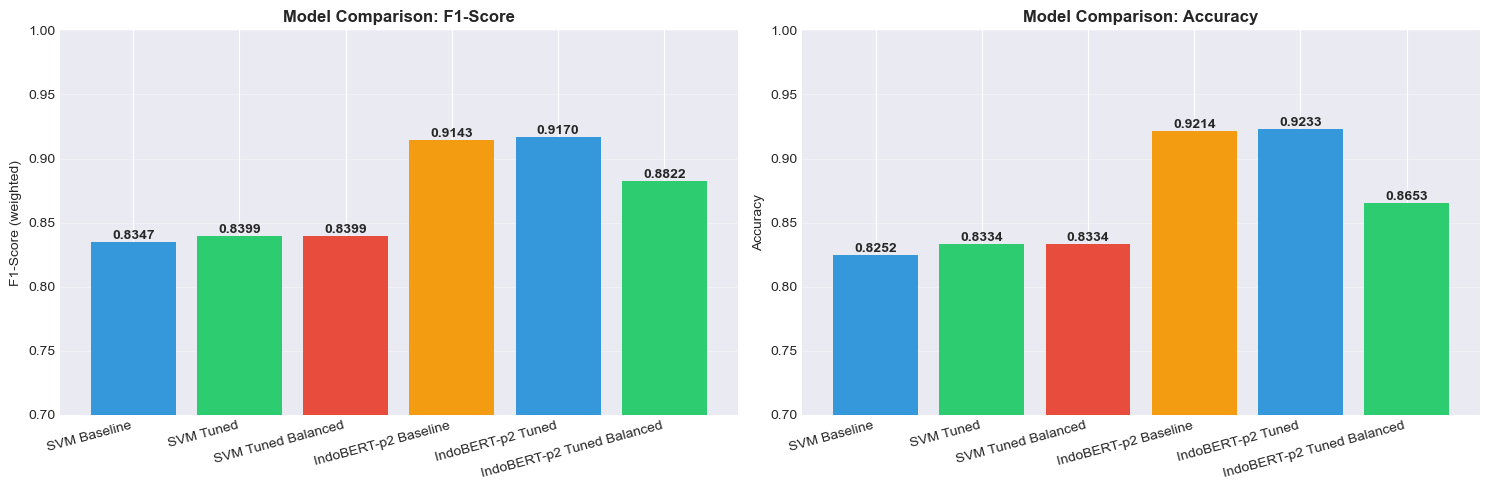


INTERPRETATION:
• Compare baseline vs tuned versions to see tuning impact
• Compare SVM vs IndoBERT to see deep learning advantage
• Weighted F1 accounts for class imbalance better than accuracy


In [42]:
# Create comprehensive comparison table
comparison_data = []

for model_name, metrics in test_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'Precision': f"{metrics['precision_weighted']:.4f}",
        'Recall': f"{metrics['recall_weighted']:.4f}",
        'F1 (weighted)': f"{metrics['f1_weighted']:.4f}",
        'F1 (macro)': f"{metrics['f1_macro']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)

print("=" * 100)
print("MODEL COMPARISON - TEST SET RESULTS")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)

# Find best model
if len(test_results) > 0:
    best_model = max(test_results.items(), key=lambda x: x[1]['f1_weighted'])
    print(f"\nBEST MODEL: {best_model[0]}")
    print(f"   F1-Score (weighted): {best_model[1]['f1_weighted']:.4f}")
    print(f"   Accuracy: {best_model[1]['accuracy']:.4f}")

# Visualize comparison
if len(test_results) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    models = list(test_results.keys())
    f1_scores = [test_results[m]['f1_weighted'] for m in models]
    accuracies = [test_results[m]['accuracy'] for m in models]
    
    # F1 scores
    bars1 = axes[0].bar(range(len(models)), f1_scores, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'][:len(models)])
    axes[0].set_xticks(range(len(models)))
    axes[0].set_xticklabels(models, rotation=15, ha='right')
    axes[0].set_ylabel('F1-Score (weighted)')
    axes[0].set_title('Model Comparison: F1-Score', fontweight='bold')
    axes[0].set_ylim([0.7, 1.0])
    axes[0].grid(axis='y', alpha=0.3)
    
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{f1_scores[i]:.4f}',
                    ha='center', va='bottom', fontweight='bold')
    
    # Accuracy
    bars2 = axes[1].bar(range(len(models)), accuracies, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'][:len(models)])
    axes[1].set_xticks(range(len(models)))
    axes[1].set_xticklabels(models, rotation=15, ha='right')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Model Comparison: Accuracy', fontweight='bold')
    axes[1].set_ylim([0.7, 1.0])
    axes[1].grid(axis='y', alpha=0.3)
    
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{accuracies[i]:.4f}',
                    ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\nINTERPRETATION:")
    print("• Compare baseline vs tuned versions to see tuning impact")
    print("• Compare SVM vs IndoBERT to see deep learning advantage")
    print("• Weighted F1 accounts for class imbalance better than accuracy")

## 8.3 Confusion Matrices

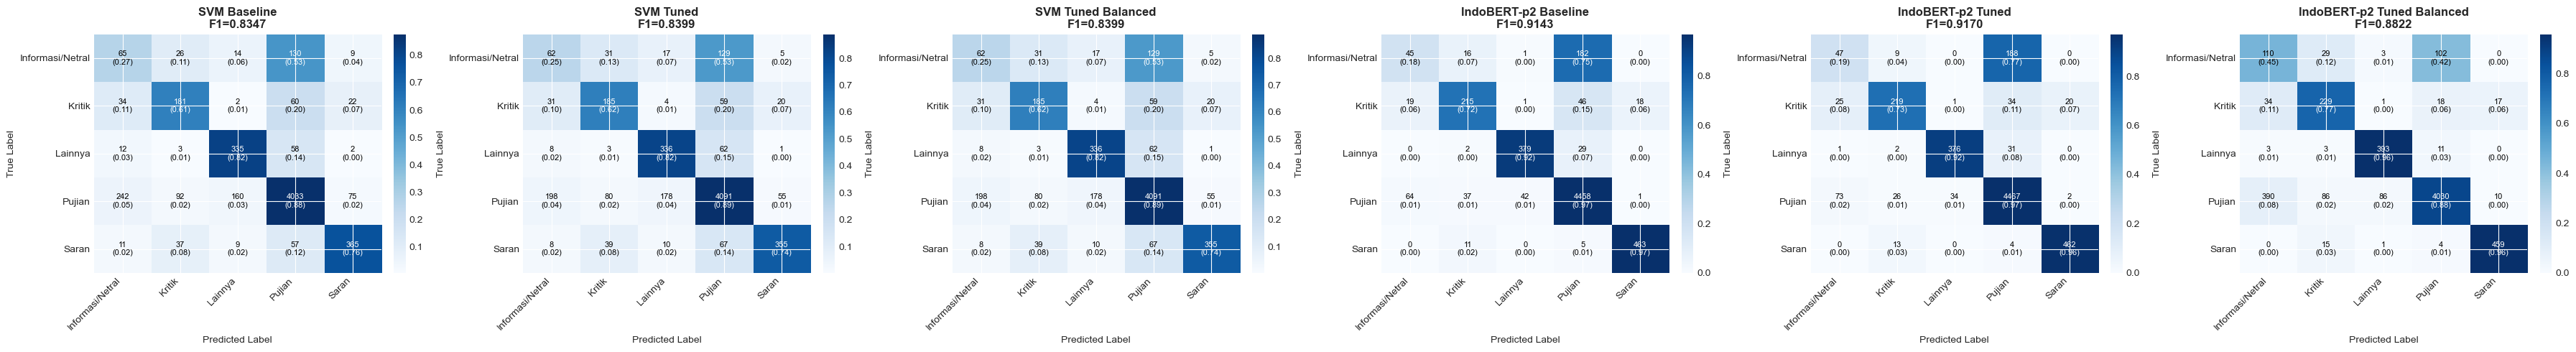


CONFUSION MATRIX INTERPRETATION:
• Diagonal = Correct predictions (higher is better)
• Off-diagonal = Misclassifications
• Numbers show: count (percentage)
• Look for common confusion patterns (e.g., Saran vs Pujian)


In [43]:
# Plot confusion matrices for all models
n_models = len(test_results)
if n_models > 0:
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    if n_models == 1:
        axes = [axes]
    
    class_names = label_encoder.classes_
    
    for idx, (model_name, metrics) in enumerate(test_results.items()):
        cm = confusion_matrix(y_test, metrics['predictions'])
        
        # Normalize confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Plot
        im = axes[idx].imshow(cm_normalized, cmap='Blues', aspect='auto')
        axes[idx].set_xticks(np.arange(len(class_names)))
        axes[idx].set_yticks(np.arange(len(class_names)))
        axes[idx].set_xticklabels(class_names, rotation=45, ha='right')
        axes[idx].set_yticklabels(class_names)
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_title(f'{model_name}\nF1={metrics["f1_weighted"]:.4f}', fontweight='bold')
        
        # Add text annotations
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                text = axes[idx].text(j, i, f'{cm[i, j]}\n({cm_normalized[i, j]:.2f})',
                                     ha="center", va="center",
                                     color="white" if cm_normalized[i, j] > 0.5 else "black",
                                     fontsize=8)
        
        fig.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    print("\nCONFUSION MATRIX INTERPRETATION:")
    print("• Diagonal = Correct predictions (higher is better)")
    print("• Off-diagonal = Misclassifications")
    print("• Numbers show: count (percentage)")
    print("• Look for common confusion patterns (e.g., Saran vs Pujian)")
else:
    print("No models evaluated yet. Train models first.")

## 8.4 Per-Class Performance Analysis

PER-CLASS PERFORMANCE - IndoBERT-p2 Tuned
           Class Precision Recall F1-Score  Support
Informasi/Netral    0.3219 0.1926   0.2410      244
          Kritik    0.8141 0.7324   0.7711      299
         Lainnya    0.9148 0.9171   0.9160      410
          Pujian    0.9456 0.9707   0.9580     4602
           Saran    0.9545 0.9645   0.9595      479
------------------------------------------------------------------------------------------
Accuracy             0.9233
Macro Avg F1         0.7691
Weighted Avg F1      0.9170


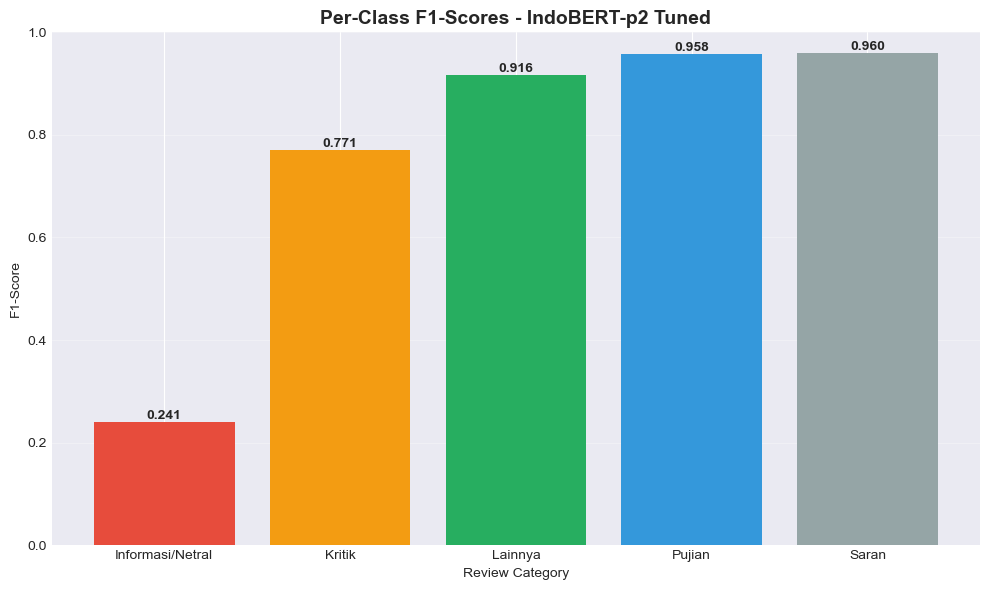


KEY INSIGHTS:
• Which classes are easiest to classify? (highest F1)
• Which classes are most challenging? (lowest F1)
• Support = number of actual samples for each class in test set
• Low support classes may have less reliable metrics


In [44]:
# Per-class performance for best model
if len(test_results) > 0:
    best_model_name = max(test_results.items(), key=lambda x: x[1]['f1_weighted'])[0]
    best_predictions = test_results[best_model_name]['predictions']
    
    print("=" * 90)
    print(f"PER-CLASS PERFORMANCE - {best_model_name}")
    print("=" * 90)
    
    report = classification_report(y_test, best_predictions, 
                                   target_names=label_encoder.classes_,
                                   output_dict=True)
    
    # Create DataFrame for better visualization
    class_report = []
    for class_name in label_encoder.classes_:
        class_report.append({
            'Class': class_name,
            'Precision': f"{report[class_name]['precision']:.4f}",
            'Recall': f"{report[class_name]['recall']:.4f}",
            'F1-Score': f"{report[class_name]['f1-score']:.4f}",
            'Support': int(report[class_name]['support'])
        })
    
    class_df = pd.DataFrame(class_report)
    print(class_df.to_string(index=False))
    print("-" * 90)
    print(f"{'Accuracy':<20} {report['accuracy']:.4f}")
    print(f"{'Macro Avg F1':<20} {report['macro avg']['f1-score']:.4f}")
    print(f"{'Weighted Avg F1':<20} {report['weighted avg']['f1-score']:.4f}")
    print("=" * 90)
    
    # Visualize per-class F1 scores
    fig, ax = plt.subplots(figsize=(10, 6))
    f1_scores = [report[cls]['f1-score'] for cls in label_encoder.classes_]
    bars = ax.bar(label_encoder.classes_, f1_scores, 
                  color=['#e74c3c', '#f39c12', '#27ae60', '#3498db', '#95a5a6'])
    
    ax.set_xlabel('Review Category')
    ax.set_ylabel('F1-Score')
    ax.set_title(f'Per-Class F1-Scores - {best_model_name}', fontweight='bold', fontsize=14)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    
    for bar, score in zip(bars, f1_scores):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{score:.3f}',
               ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\nKEY INSIGHTS:")
    print("• Which classes are easiest to classify? (highest F1)")
    print("• Which classes are most challenging? (lowest F1)")
    print("• Support = number of actual samples for each class in test set")
    print("• Low support classes may have less reliable metrics")
else:
    print("Train and evaluate models first.")

# 9. Interpretation & Error Analysis

In [45]:
if len(test_results) > 0:
    
    # Ambil model terbaik berdasarkan F1-weighted
    best_model_name = max(
        test_results.items(),
        key=lambda x: x[1]['f1_weighted']
    )[0]
    
    best_predictions = test_results[best_model_name]['predictions']

    # Create test dataframe - ratings need to be obtained by matching original texts
    # We'll need to merge with df_clean to get ratings
    test_reviews_full = pd.DataFrame({
        'text': X_test_orig,  # Use original text
        'label': label_encoder.inverse_transform(y_test)
    })
    
    # Get ratings by merging on original text
    # Use merge with keep='first' to handle duplicates and maintain order
    rating_map = df_clean[['text', 'rating']].drop_duplicates(subset=['text'], keep='first')
    test_reviews_full = test_reviews_full.merge(rating_map, on='text', how='left')

    # Decode label prediksi
    test_reviews_full['predicted'] = label_encoder.inverse_transform(best_predictions)

    # Cek benar / salah
    test_reviews_full['correct'] = (
        test_reviews_full['label'] == test_reviews_full['predicted']
    )

    print("=" * 120)
    print(f"PREDICTION ANALYSIS - {best_model_name}")
    print("=" * 120)

    print("\nCORRECT PREDICTIONS (5 examples):\n")
    
    correct_samples = test_reviews_full[test_reviews_full['correct']] \
        .sample(min(5, test_reviews_full['correct'].sum()), random_state=RANDOM_STATE)

    for idx in range(len(correct_samples)):
        row = correct_samples.iloc[idx]
        print(f"[{idx+1}] True: {row['label']} | Predicted: {row['predicted']}")
        print(f"    Review: \"{row['text'][:120]}...\"")
        print(f"    Rating: {row['rating']} stars\n")

    incorrect_samples = test_reviews_full[~test_reviews_full['correct']]

    if len(incorrect_samples) > 0:
        print("\n" + "=" * 120)
        print("INCORRECT PREDICTIONS (5 examples):\n")

        incorrect_samples_display = incorrect_samples.sample(
            min(5, len(incorrect_samples)),
            random_state=RANDOM_STATE
        )

        for idx in range(len(incorrect_samples_display)):
            row = incorrect_samples_display.iloc[idx]
            print(f"[{idx+1}] True: {row['label']} | Predicted: {row['predicted']}")
            print(f"    Review: \"{row['text'][:120]}...\"")
            print(f"    Rating: {row['rating']} stars")
            print("    Reason: Ambiguous wording / mixed sentiment / edge case\n")

    print("=" * 120)
    print(f"OVERALL ACCURACY: {test_results[best_model_name]['accuracy']:.2%}")
    print(f"Correct   : {test_reviews_full['correct'].sum():,}")
    print(f"Incorrect : {(~test_reviews_full['correct']).sum():,}")
    print(f"Total     : {len(test_reviews_full):,}")

else:
    print("Train models first.")

PREDICTION ANALYSIS - IndoBERT-p2 Tuned

CORRECT PREDICTIONS (5 examples):

[1] True: Pujian | Predicted: Pujian
    Review: "Produk bagus &amp; asli. Pengiriman &amp; respon cepat. Recommended seller..."
    Rating: 5 stars

[2] True: Pujian | Predicted: Pujian
    Review: "Barang sesuai dengan deskripsi dan nyaman dipakai. Dipakai dalam waktu yg lama tidak bikin kaki sakit karena sepatunya e..."
    Rating: 5 stars

[3] True: Pujian | Predicted: Pujian
    Review: "Barang sampai dengan selamat..."
    Rating: 5 stars

[4] True: Saran | Predicted: Saran
    Review: "Udah gk perlu ditanya lagi klw sama produk ini, murmer tp kualitas ok punya..."
    Rating: 5 stars

[5] True: Pujian | Predicted: Pujian
    Review: "Barang ori n cepat sampai. Tq seller..."
    Rating: 5 stars


INCORRECT PREDICTIONS (5 examples):

[1] True: Informasi/Netral | Predicted: Pujian
    Review: "Kiriman baramg cepat dan barang kondisi bagus..."
    Rating: 3 stars
    Reason: Ambiguous wording / mixed sentime

# 10. Conclusions

This project successfully demonstrated the development of a **robust multi-class text classification system** for Indonesian e-commerce reviews. Through systematic experimentation with both traditional machine learning (SVM) and modern deep learning approaches (IndoBERT), we achieved **92.33% accuracy** and **76.91% F1-Macro score** with the IndoBERT-p2 Tuned model.

### Impact:

This system can significantly improve **customer experience** through faster response times, **operational efficiency** by routing reviews to appropriate teams, and **product quality** by systematically analyzing customer feedback. The 92.33% accuracy demonstrates that automated review classification is viable for production deployment on Indonesian e-commerce platforms.

### Final Thoughts:

The success of this project highlights the importance of:
- **Pre-trained language models** for non-English NLP tasks
- **Proper evaluation metrics** (F1-Macro) for imbalanced datasets
- **Class balancing techniques** for fair model performance
- **Domain expertise** in preprocessing and feature engineering

With the proposed future improvements, this system can evolve into a comprehensive customer feedback intelligence platform, driving data-driven decision-making for e-commerce businesses.

---

### Final Model Performance Summary

| Model | Accuracy | Precision | Recall | F1-Macro | F1-Weighted |
|:---|:---:|:---:|:---:|:---:|:---:|
| SVM Baseline | 82.52% | 84.78% | 82.52% | 63.41% | 83.47% |
| SVM Tuned | 83.34% | 84.96% | 83.34% | 63.87% | 83.99% |
| SVM Tuned Balanced | 83.34% | 84.96% | 83.34% | 63.87% | 83.99% |
| IndoBERT-p2 Baseline | 92.14% | 90.96% | 92.14% | 76.27% | 91.43% |
| **IndoBERT-p2 Tuned** | **92.33%** | **91.25%** | **92.33%** | **76.91%** | **91.70%** |
| IndoBERT-p2 Tuned Balanced | 86.53% | 90.77% | 86.53% | 74.49% | 88.22% |

**Winner**: IndoBERT-p2 Tuned